# Test Hydra Config

In [1]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf

abs_config_dir = os.path.abspath("config/")

In [7]:

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config = compose(config_name="main.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config)

dataset = hydra.utils.instantiate(
    config.dataset,
    float_precision=config.float_precision,
)

oracle = hydra.utils.instantiate(
    config.oracle,
    device=config.device,
    float_precision=config.float_precision,
)

filter = hydra.utils.instantiate(
    config.filter,
    oracle=oracle,
)

surrogate = hydra.utils.instantiate(
    config.surrogate,
    device=config.device,
    float_precision=config.float_precision,
    maximize=config.maximize,
)

sampler = hydra.utils.instantiate(
    config.sampler,
    surrogate=surrogate,
)
sampler

{'device': 'cuda', 'float_precision': 64, 'budget': 5, 'n_samples': 3, 'seed': 31415, 'maximize': False, 'dataset': {'_target_': 'dataset.dataset.BraninDatasetHandler', 'grid_size': 10, 'normalize_scores': True, 'train_fraction': 1.0, 'batch_size': 16, 'shuffle': True, 'train_path': 'storage/branin/data_10_train.csv', 'test_path': None}, 'oracle': {'_target_': 'gflownet.proxy.box.branin.Branin', 'fidelity': '1,', 'do_domain_map': True}, 'filter': {'_target_': 'filter.filter.Filter'}, 'logger': {'_target_': 'utils.logger.Logger', 'do': {'online': True, 'times': True}, 'project_name': 'MF-AL-GFN', 'train': {'period': 1}, 'test': {'first_it': True, 'period': 100, 'n': 100, 'kde': {'bandwidth': 0.1, 'kernel': 'gaussian'}, 'n_top_k': 5000, 'top_k': 100, 'top_k_period': -1, 'n_trajs_logprobs': 10, 'logprobs_batch_size': 100, 'logprobs_bootstrap_size': 10000, 'max_data_logprobs': 100000.0}, 'oracle': {'period': 100000, 'k': [1, 10, 100]}, 'context': '0', 'notes': None, 'ckpts': {'policy': {'p

# Active Learning Loop

In [1]:

# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf
abs_config_dir = os.path.abspath("config/")


# init logger
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_logger = compose(config_name="logger/wandb.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_logger)

logger = hydra.utils.instantiate(
    config_logger.logger,
    config_logger,
    _recursive_=False,
)


{'logger': {'_target_': 'gflownet.utils.logger.Logger', 'do': {'online': True, 'times': False}, 'project_name': 'ActiveLearningLoop_Test', 'train': {'period': 1}, 'test': {'first_it': True, 'period': 100, 'n': 100, 'kde': {'bandwidth': 0.1, 'kernel': 'gaussian'}, 'n_top_k': 5000, 'top_k': 100, 'top_k_period': -1, 'n_trajs_logprobs': 10, 'logprobs_batch_size': 100, 'logprobs_bootstrap_size': 10000, 'max_data_logprobs': 100000.0}, 'oracle': {'period': 100000, 'k': [1, 10, 100]}, 'checkpoints': {'period': 1000}, 'logdir': {'root': './logs', 'ckpts': 'ckpts', 'overwrite': True}, 'debug': False, 'lightweight': False, 'progress': True, 'context': '0', 'notes': None, 'tags': ['gflownet']}}


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: christina-humer. Use `wandb login --relogin` to force relogin


In [2]:
def get_gflownet_sampler(surrogate, logger):
    with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
        config_sampler = compose(config_name="sampler/gflownet.yaml", overrides=[])
        # print(OmegaConf.to_yaml(config_sampler))
        print(config_sampler)

    sampler = hydra.utils.instantiate(
        config_sampler.sampler,
        surrogate=surrogate,
        logger=logger,
        device=device,
        float_precision=float_prec,
        _recursive_=False,
    )
    return sampler

In [3]:
from utils.plotter import PlotHelper
# plotter = PlotHelper(logger)
plotter = PlotHelper()

In [4]:
import torch

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
import numpy as np

n_iterations = 5  # TODO: replace with budget
grid_size = 10

from gflownet.utils.common import set_float_precision
# float_prec = set_float_precision(64)
float_prec = set_float_precision(32)
# float_prec = torch.double
n_samples = 3
maximize = False

# # define candidate set
# xi = np.arange(0, grid_size)
# yi = np.arange(0, grid_size)
# grid = np.array(np.meshgrid(xi, yi))
# grid_flat = torch.tensor(grid.T, dtype=float_prec).reshape(-1, 2)
# from dataset.dataset import Branin_Data

# candidate_set, _ = Branin_Data(grid_size, grid_flat)[:]
# xi = xi / grid_size
# yi = yi / grid_size


import matplotlib.colors as cm
import matplotlib.pyplot as plt
# colors = ["red", "blue", "green", "orange", "brown", "pink"]
colors = plt.get_cmap("Reds")

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'sampler/gflownet.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


{'sampler': {'conf': {'state_flow': None, 'policy': {'forward': {'_target_': 'gflownet.policy.base.Policy', 'config': {'type': 'mlp', 'n_hid': 128, 'n_layers': 2, 'checkpoint': None, 'reload_ckpt': False, 'is_model': False}}, 'backward': {'_target_': 'gflownet.policy.base.Policy', 'config': None}, 'shared': None}, 'env': {'_target_': 'gflownet.envs.grid.Grid', 'id': 'grid', 'func': 'corners', 'n_dim': 2, 'length': 10, 'max_increment': 1, 'max_dim_per_action': 1, 'cell_min': 0, 'cell_max': 0.9, 'buffer': {'data_path': None, 'train': None, 'test': {'type': 'all', 'output_csv': 'grid_test.csv', 'output_pkl': 'grid_test.pkl'}}, 'reward_func': 'identity', 'reward_min': 1e-08, 'reward_beta': 1.0, 'reward_norm': 1.0, 'reward_norm_std_mult': 0.0, 'proxy_state_format': 'oracle', 'skip_mask_check': False, 'conditional': False, 'continuous': False}, 'agent': {'_target_': 'gflownet.gflownet.GFlowNetAgent', 'seed': 0, 'optimizer': {'z_dim': 16, 'loss': 'trajectorybalance', 'lr': 0.0001, 'lr_decay_p

  0%|          | 0/500 [00:00<?, ?it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:05<?, ?it/s]
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/gflownet/utils/buffer.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.main = pd.concat(
Loss: 2099.9043 | Mean rewards: 0.00 | JSD: 0.4579:  20%|█▉        | 99/500 [00:35<01:58,  3.37it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:05<?, ?it/s]
Loss: 1023.7711 | Mean rewards: 0.00 | JSD: 0.4537:  40%|███▉      | 199/500 [01:10<01:29,  3.37it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:05<?, ?it/s]
Loss: 437.9561 | Mean rewards: 0.00 | JSD: 0.3354:  60%|█████▉    | 299/500 [01:45<00:58,  3.45it/s] 

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:05<?, ?it/s]
Loss: 164.8618 | Mean rewards: 0.00 | JSD: 0.4007:  80%|███████▉  | 399/500 [02:21<00:29,  3.42it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:05<?, ?it/s]
Loss: 51.7119 | Mean rewards: 0.00 | JSD: 0.4007: 100%|█████████▉| 499/500 [02:59<00:00,  2.94it/s] 

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:05<?, ?it/s]
Loss: 51.2229 | Mean rewards: 0.00 | JSD: 0.4110: 100%|██████████| 500/500 [03:05<00:00,  2.69it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


BS Std(logp) / NLL,▃▁▁▃▂█
Jensen Shannon Div.,██▁▅▅▅
KL Div.,██▁▅▅▆
L1 error,██▁▅▅▆
Loss,██▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss (non-term.),██▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss (terminating),██▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Mean BS Std(logp),█▄▂▃▁▄
Mean BS Std(p),▃▁▄▄▅█
NLL of test data,█▆▆▄▃▁
Var(logR - logp) test,█▅▆▄▃▁


Error: You must call wandb.init() before wandb.log()

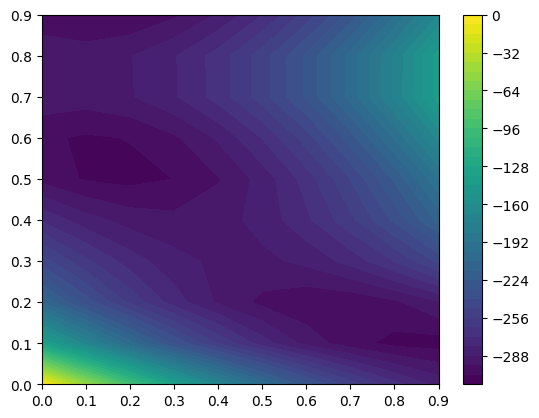

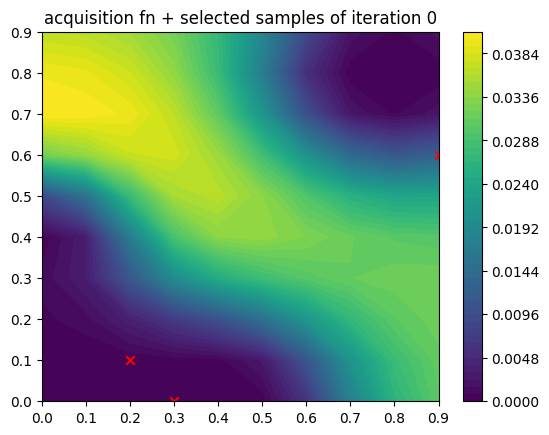

In [5]:
from dataset.dataset import BraninDatasetHandler
from surrogate.surrogate import SingleTaskGPRegressor
from sampler.sampler import GreedySampler, RandomSampler
from filter.filter import Filter, OracleFilter
from gflownet.proxy.box.branin import Branin


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=grid_size,
    train_path="./storage/branin/data_%i_train.csv" % grid_size,
    train_fraction=1.0,
    float_precision=float_prec,
)

candidate_set, xi, yi = dataset_handler.get_candidate_set()

# Oracle
oracle = Branin(
    fidelity=1, do_domain_map=True, device=device, float_precision=float_prec
)
# Filter
filter = Filter()
# filter = OracleFilter(oracle)

if plotter is not None:
    fig_oracle, ax_oracle = plotter.plot_function(oracle, candidate_set.clone().to(device), xi=xi, yi=yi)


best_scores = []

for i in range(n_iterations):

    train_data, test_data = dataset_handler.get_dataloader()
    # print("iteration", i)
    # Surrogate (e.g., Bayesian Optimization)
    # starts with a clean slate each iteration
    surrogate = SingleTaskGPRegressor(
        float_precision=float_prec, device=device, maximize=maximize
    )
    surrogate.fit(train_data)

    # Sampler (e.g., GFlowNet, or Random Sampler)
    # also starts with a clean slate; TODO: experiment with NOT training from scratch
    # sampler = RandomSampler(surrogate)
    # sampler = GreedySampler(surrogate)
    sampler = get_gflownet_sampler(surrogate, logger)

    sampler.fit()  # only necessary for samplers that train a model

    samples = sampler.get_samples(
        n_samples * 3, candidate_set=candidate_set.clone().to(device)
    )
    filtered_samples = filter(
        n_samples=n_samples, candidate_set=samples.clone(), maximize=maximize
    )
    
    if plotter is not None:
        fig_acq, ax_acq = plotter.plot_function(surrogate, candidate_set.clone().to(device), xi=xi, yi=yi)
        fig_acq, ax_acq = plotter.plot_samples(filtered_samples, ax_acq, fig_acq)
        ax_acq.set_title("acquisition fn + selected samples of iteration %i"%i)
        plotter.log_figure(fig_acq, "acq")

    if ax_oracle is not None:
        ax_oracle.scatter(
            x=filtered_samples[:, 0].cpu(),
            y=filtered_samples[:, 1].cpu(),
            c=cm.to_hex(colors(i / n_iterations)),
            marker="x",
            label="it %i" % i,
        )

    scores = oracle(filtered_samples.clone())
    dataset_handler.update_dataset(filtered_samples.cpu(), scores.cpu())
    best_scores.append(scores.min().cpu())

if ax_oracle is not None:
    fig_oracle.legend()
    ax_oracle.set_title("oracle fn + samples")
    plotter.log_figure(fig_oracle, key="oracle")


fig = plt.figure()
plt.plot(best_scores)
plt.xlabel("iterations")
plt.ylabel("scores")
plt.title("Best Score in each iteration")
if plotter is not None:
    plotter.log_figure(fig, key="best_scores")

# Test individual components

In [2]:
import os

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)


from gflownet.utils.common import set_float_precision
float_prec = set_float_precision(64)
# float_prec = torch.double

import numpy as np
grid_size = 10  # 100
test_states = torch.tensor([[0.5, 0.5]])
test_scores = torch.tensor([-150.0])
n_samples = 5

baseline_states = torch.tensor(
    [
        [0.0 * grid_size, 0.0 * grid_size],
        [0.0 * grid_size, 0.4 * grid_size],
        [0.4 * grid_size, 0.0 * grid_size],
        [0.8 * grid_size, 0.8 * grid_size],
    ]
)

# define grid space
xi = np.arange(0, 1, 1 / grid_size)
yi = np.arange(0, 1, 1 / grid_size)
grid = np.array(np.meshgrid(xi, yi))
grid_flat = torch.tensor(grid.T, dtype=float_prec).reshape(-1, 2).to(device)

cuda


In [3]:
# dataset
from dataset.dataset import BraninDatasetHandler

dataset_handler = BraninDatasetHandler(
    grid_size=grid_size,
    train_path="./storage/branin/data_%i_train.csv" % grid_size,
    train_fraction=1.0,
    float_precision=float_prec,
)

# testing dataset
dataset_handler.update_dataset(test_states, test_scores)
print(dataset_handler.train_data.X_data, dataset_handler.train_data.y_data)
print(dataset_handler.train_data[:])
train_loader, test_loader = dataset_handler.get_dataloader()
for X, y in train_loader:
    print(X, y)

tensor([[0., 0.],
        [0., 4.],
        [4., 0.],
        [8., 8.],
        [5., 5.]], dtype=torch.float64) tensor([  -0.8709, -171.1192, -273.2218, -174.8874, -150.0000],
       dtype=torch.float64)
(tensor([[0.0000, 0.0000],
        [0.0000, 0.4000],
        [0.4000, 0.0000],
        [0.8000, 0.8000],
        [0.5000, 0.5000]], dtype=torch.float64), tensor([1.0000, 0.3749, 0.0000, 0.3611, 0.4524], dtype=torch.float64))
tensor([[0.4000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.4000],
        [0.5000, 0.5000],
        [0.8000, 0.8000]], dtype=torch.float64) tensor([0.0000, 1.0000, 0.3749, 0.4524, 0.3611], dtype=torch.float64)


tensor([  -0.8709, -171.1192, -273.2218, -174.8874], device='cuda:0',
       dtype=torch.float64)


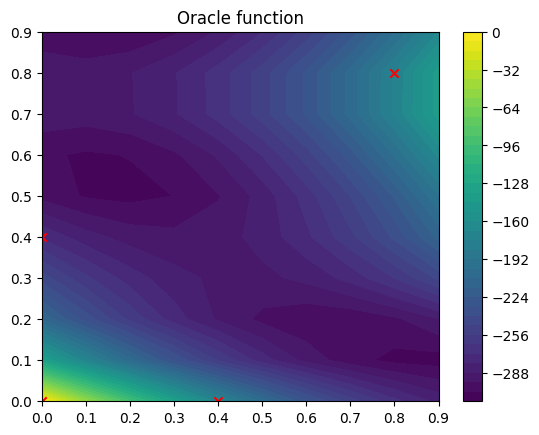

In [4]:
# Oracle
from gflownet.proxy.box.branin import Branin

oracle = Branin(fidelity=1, do_domain_map=True, device=device, float_precision=float_prec)

# testing oracle
print(oracle(baseline_states.to(device).clone() / grid_size))

# plot oracle function
plot_function(oracle, grid_flat.clone(), scatter_markers=baseline_states / grid_size)
plt.title("Oracle function")
plt.show()

tensor([-0.4285], device='cuda:0', dtype=torch.float64) tensor([0.1735], device='cuda:0', dtype=torch.float64)


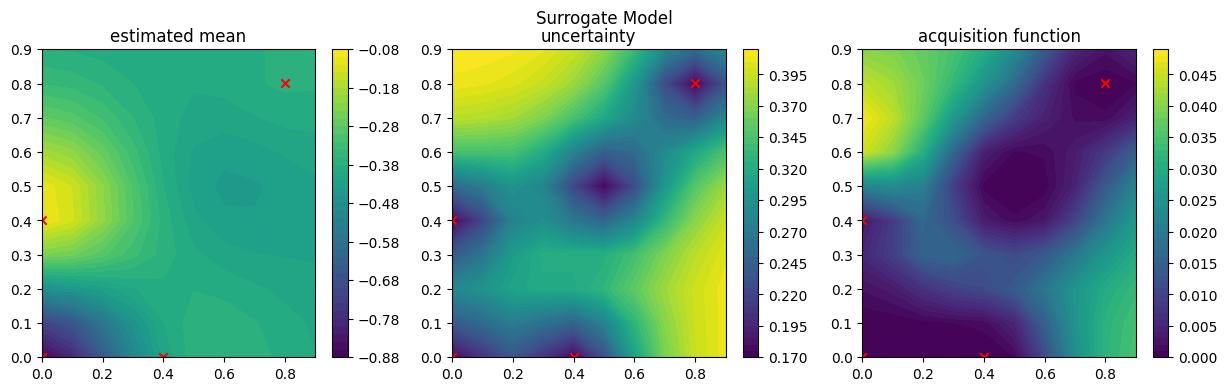

In [5]:
# Surrogate (e.g., Bayesian Optimization)
from surrogate.surrogate import SingleTaskGPRegressor

surrogate = SingleTaskGPRegressor(device=device, float_precision=float_prec, maximize=False)
train_data, test_data = dataset_handler.get_dataloader()
surrogate.fit(train_data)

# testing surrogate
preds_mean, preds_var = surrogate.get_predictions(test_states / grid_size)
print(preds_mean, preds_var)

# plot surrogate functions
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

plot_function(
    surrogate.get_predictions,
    grid_flat.clone(),
    fig=fig,
    ax=axes[0],
    scatter_markers=baseline_states / grid_size,
    output_index=0,
)
axes[0].set_title("estimated mean")

plot_function(
    surrogate.get_predictions,
    grid_flat.clone(),
    fig=fig,
    ax=axes[1],
    scatter_markers=baseline_states / grid_size,
    output_index=1,
)
axes[1].set_title("uncertainty")

plot_function(
    surrogate.get_acquisition_values,
    grid_flat.clone(),
    fig=fig,
    ax=axes[2],
    scatter_markers=baseline_states / grid_size,
)
axes[2].set_title("acquisition function")

fig.suptitle("Surrogate Model")
plt.show()

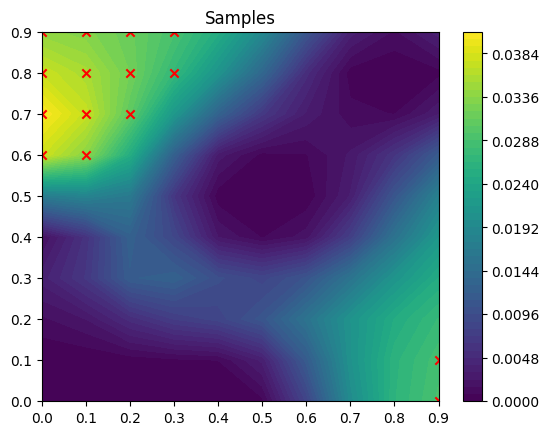

In [6]:
# Sampler (e.g., GFlowNet, or Random Sampler)
from sampler.sampler import GreedySampler, RandomSampler

sampler = GreedySampler(surrogate)
# sampler = RandomSampler(surrogate)
sampler.fit()
samples = sampler.get_samples(n_samples * 3, grid_flat.clone()).cpu()

# plot acq function with proposed candidates
fig, ax = plot_function(
    surrogate.get_acquisition_values, grid_flat.clone(), scatter_markers=samples
)
plt.title("Samples")
plt.show()

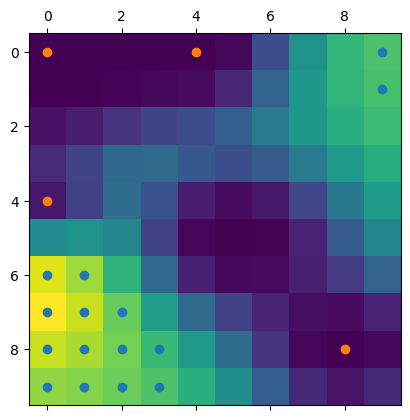

In [7]:
acq = surrogate.get_acquisition_values(grid_flat.clone()).detach().cpu()
plt.matshow(acq.reshape(int(len(acq) ** (1 / 2)), int(len(acq) ** (1 / 2))))
plt.scatter(samples.cpu()[:, 1] * grid_size, samples.cpu()[:, 0] * grid_size)
plt.scatter(baseline_states[:, 1].cpu(), baseline_states[:, 0].cpu())

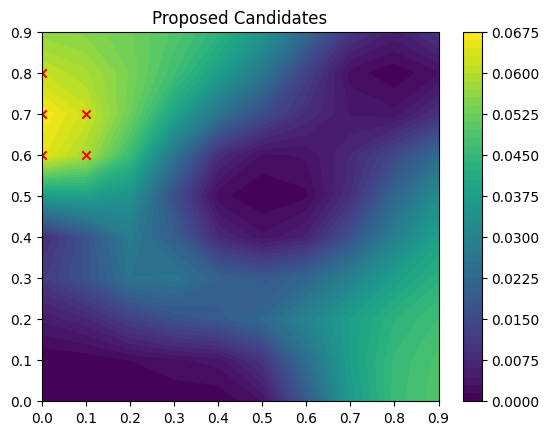

In [8]:
from filter.filter import Filter, OracleFilter

filter = Filter()
# filter = OracleFilter(oracle)
filtered_samples = filter(n_samples, samples)

# plot oracle function with proposed candidates
fig, ax = plot_function(
    surrogate.get_acquisition_values,
    grid_flat.clone(),
    scatter_markers=filtered_samples.to("cpu"),
)
plt.title("Proposed Candidates")
plt.show()

# GFlowNet Sampler

In [9]:
import torch
float_prec = torch.float32
device = "cpu"
grid_size = 10

In [10]:
# dataset
from dataset.dataset import BraninDatasetHandler

dataset_handler = BraninDatasetHandler(
    grid_size=grid_size,
    train_path="./storage/branin/data_%i_train.csv" % grid_size,
    train_fraction=1.0,
    float_precision=float_prec,
)


In [11]:
train_data, _ = dataset_handler.get_dataloader()
for r in train_data:
    print(r)

[tensor([[0.0000, 0.4000],
        [0.0000, 0.0000],
        [0.4000, 0.0000],
        [0.8000, 0.8000]]), tensor([0.3749, 1.0000, 0.0000, 0.3611])]


In [12]:
from importlib import reload  # Python 3.4+
import surrogate.surrogate as surrogate

reload(surrogate)

from surrogate.surrogate import SingleTaskGPRegressor

surrogate = SingleTaskGPRegressor(device=device, float_precision=float_prec, maximize=False)
train_data, test_data = dataset_handler.get_dataloader()
surrogate.fit(train_data)

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)


In [16]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf

abs_config_dir = os.path.abspath("config/")


In [17]:
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_logger = compose(config_name="logger/wandb.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_logger)

logger = hydra.utils.instantiate(config_logger.logger, config_logger, _recursive_=False)

{'logger': {'_target_': 'gflownet.utils.logger.Logger', 'do': {'online': False, 'times': False}, 'project_name': 'GFlowNet', 'train': {'period': 1}, 'test': {'first_it': True, 'period': 100, 'n': 100, 'kde': {'bandwidth': 0.1, 'kernel': 'gaussian'}, 'n_top_k': 5000, 'top_k': 100, 'top_k_period': -1, 'n_trajs_logprobs': 10, 'logprobs_batch_size': 100, 'logprobs_bootstrap_size': 10000, 'max_data_logprobs': 100000.0}, 'oracle': {'period': 100000, 'k': [1, 10, 100]}, 'checkpoints': {'period': 1000}, 'logdir': {'root': './logs', 'ckpts': 'ckpts', 'overwrite': True}, 'debug': False, 'lightweight': False, 'progress': True, 'context': '0', 'notes': None, 'tags': ['gflownet']}}


In [15]:
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_logger = compose(config_name="logger/wandb.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_logger)

# Logger
# from utils.logger import Logger

# logger = Logger(config=OmegaConf.create(), **config_logger)
logger = hydra.utils.instantiate(config_logger.logger, config_logger, _recursive_=False)

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_sampler = compose(config_name="sampler/gflownet.yaml", overrides=[])
    # print(OmegaConf.to_yaml(config_sampler))
    print(config_sampler)

grid_env = hydra.utils.instantiate(
    config_sampler.sampler.conf.env,
    proxy=surrogate,
    device=device,
    float_precision=float_prec,
)

# The policy is used to model the probability of a forward/backward action
forward_policy = hydra.utils.instantiate(
    config_sampler.sampler.conf.policy.forward,
    env=grid_env,
    device=device,
    float_precision=float_prec,
)
backward_policy = hydra.utils.instantiate(
    config_sampler.sampler.conf.policy.backward,
    env=grid_env,
    device=device,
    float_precision=float_prec,
)

# State flow
if config_sampler.sampler.conf.state_flow is not None:
    state_flow = hydra.utils.instantiate(
        config_sampler.sampler.conf.state_flow,
        env=grid_env,
        device=device,
        float_precision=float_prec,
        base=forward_policy,
    )
else:
    state_flow = None

# GFlowNet Agent
sampler = hydra.utils.instantiate(
    config_sampler.sampler.conf.agent,
    device=device,
    float_precision=float_prec,
    env=grid_env,
    forward_policy=forward_policy,
    backward_policy=backward_policy,
    state_flow=state_flow,
    buffer=config_sampler.sampler.conf.env.buffer,
    logger=logger,
)

{'logger': {'_target_': 'gflownet.utils.logger.Logger', 'do': {'online': False, 'times': False}, 'project_name': 'GFlowNet', 'train': {'period': 1}, 'test': {'first_it': True, 'period': 100, 'n': 100, 'kde': {'bandwidth': 0.1, 'kernel': 'gaussian'}, 'n_top_k': 5000, 'top_k': 100, 'top_k_period': -1, 'n_trajs_logprobs': 10, 'logprobs_batch_size': 100, 'logprobs_bootstrap_size': 10000, 'max_data_logprobs': 100000.0}, 'oracle': {'period': 100000, 'k': [1, 10, 100]}, 'checkpoints': {'period': 1000}, 'logdir': {'root': './logs', 'ckpts': 'ckpts', 'overwrite': True}, 'debug': False, 'lightweight': False, 'progress': True, 'context': '0', 'notes': None, 'tags': ['gflownet']}}
{'sampler': {'conf': {'state_flow': None, 'policy': {'forward': {'_target_': 'gflownet.policy.base.Policy', 'config': {'type': 'mlp', 'n_hid': 128, 'n_layers': 2, 'checkpoint': None, 'reload_ckpt': False, 'is_model': False}}, 'backward': {'_target_': 'gflownet.policy.base.Policy', 'config': None}, 'shared': None}, 'env':

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'sampler/gflownet.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)



            Important: offline trajectories will NOT be sampled. In order to sample
            offline trajectories, the train configuration of the buffer should be
            complete and feasible and an output pkl file should be defined in
            env.buffer.train.output_pkl.
            

Constructing data set 
Test data
	Mean score: 0.021786538063499405
	Std score: 0.015443492875630887
	Min score: 0.0
	Max score: 0.04475913196802139


In [22]:
sampler.train()

  0%|          | 0/2000 [00:00<?, ?it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Loss: 1267.0955 | Mean rewards: 0.00 | JSD: 0.4480:   5%|▍         | 99/2000 [00:10<02:00, 15.75it/s] 

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 566.4079 | Mean rewards: 0.00 | JSD: 0.4863:  10%|▉         | 197/2000 [00:21<02:17, 13.15it/s] 

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 217.5760 | Mean rewards: 0.00 | JSD: 0.4857:  15%|█▍        | 298/2000 [00:31<01:54, 14.90it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 75.5657 | Mean rewards: 0.00 | JSD: 0.4819:  20%|█▉        | 398/2000 [00:43<02:26, 10.93it/s] 

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 22.4302 | Mean rewards: 0.00 | JSD: 0.4736:  25%|██▍       | 497/2000 [00:53<01:47, 13.96it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 6.7583 | Mean rewards: 0.00 | JSD: 0.4414:  30%|██▉       | 598/2000 [01:04<01:39, 14.04it/s] 

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 2.7254 | Mean rewards: 0.00 | JSD: 0.4417:  35%|███▍      | 699/2000 [01:15<02:10,  9.98it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 1.9886 | Mean rewards: 0.00 | JSD: 0.4118:  40%|███▉      | 799/2000 [01:26<01:16, 15.62it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 1.4535 | Mean rewards: 0.00 | JSD: 0.3518:  45%|████▍     | 899/2000 [01:38<01:13, 15.07it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 1.0444 | Mean rewards: 0.00 | JSD: 0.2900:  50%|████▉     | 998/2000 [01:50<01:27, 11.44it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 0.9461 | Mean rewards: 0.00 | JSD: 0.2765:  55%|█████▍    | 1099/2000 [02:02<01:15, 11.95it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 0.8774 | Mean rewards: 0.00 | JSD: 0.2417:  60%|█████▉    | 1199/2000 [02:15<01:04, 12.48it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 0.7211 | Mean rewards: 0.00 | JSD: 0.2304:  65%|██████▍   | 1298/2000 [02:27<00:53, 13.22it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 0.6952 | Mean rewards: 0.00 | JSD: 0.2176:  70%|██████▉   | 1398/2000 [02:39<00:52, 11.57it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 0.6248 | Mean rewards: 0.00 | JSD: 0.1933:  75%|███████▍  | 1499/2000 [02:51<00:34, 14.39it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 0.4038 | Mean rewards: 0.00 | JSD: 0.2149:  80%|███████▉  | 1599/2000 [03:03<00:31, 12.73it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 0.3274 | Mean rewards: 0.00 | JSD: 0.2172:  85%|████████▍ | 1698/2000 [03:16<00:23, 13.06it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 0.2406 | Mean rewards: 0.00 | JSD: 0.1974:  90%|████████▉ | 1798/2000 [03:28<00:14, 14.28it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 0.1768 | Mean rewards: 0.00 | JSD: 0.1754:  95%|█████████▍| 1898/2000 [03:41<00:09, 11.07it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 0.1342 | Mean rewards: 0.00 | JSD: 0.1622: 100%|█████████▉| 1999/2000 [03:53<00:00, 12.17it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...


Done computing logprobs


  0%|          | 0/100 [00:03<?, ?it/s]
Loss: 0.1342 | Mean rewards: 0.00 | JSD: 0.1831: 100%|██████████| 2000/2000 [03:57<00:00,  8.43it/s]


In [20]:
batch, times = sampler.sample_batch(n_forward=10, train=False)

In [21]:
batch.get_terminating_states(proxy=True)

tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.1111],
        [0.1111, 0.0000],
        [0.1111, 0.0000],
        [0.1111, 0.1111],
        [0.0000, 0.2222],
        [0.2222, 0.1111],
        [0.4444, 0.0000]])

In [ ]:
sampler

{'sampler': {'conf': {'state_flow': None, 'policy': {'forward': {'_target_': 'gflownet.policy.base.Policy', 'config': {'type': 'mlp', 'n_hid': 128, 'n_layers': 2, 'checkpoint': None, 'reload_ckpt': False, 'is_model': False}}, 'backward': {'_target_': 'gflownet.policy.base.Policy', 'config': None}, 'shared': None}, 'env': {'_target_': 'gflownet.envs.grid.Grid', 'id': 'grid', 'func': 'corners', 'n_dim': 2, 'length': 3, 'max_increment': 1, 'max_dim_per_action': 1, 'cell_min': -1, 'cell_max': 1, 'buffer': {'data_path': None, 'train': None, 'test': {'type': 'all', 'output_csv': 'grid_test.csv', 'output_pkl': 'grid_test.pkl'}}, 'reward_func': 'identity', 'reward_min': 1e-08, 'reward_beta': 1.0, 'reward_norm': 1.0, 'reward_norm_std_mult': 0.0, 'proxy_state_format': 'oracle', 'skip_mask_check': False, 'conditional': False, 'continuous': False}, 'agent': {'_target_': 'gflownet.gflownet.GFlowNetAgent', 'seed': 0, 'optimizer': {'z_dim': 16, 'loss': 'trajectorybalance', 'lr': 0.0001, 'lr_decay_per

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'sampler/gflownet.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [8]:
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_sampler = compose(config_name="sampler/gflownet.yaml", overrides=[])
    # print(OmegaConf.to_yaml(config_sampler))
    print(config_sampler)
    
sampler = hydra.utils.instantiate(
    config_sampler.sampler,
    surrogate=surrogate,
    logger=logger,
    device=device,
    float_precision=float_prec,
)


init
grid_env
forward_policy
backward_policy
state_flow

            Important: offline trajectories will NOT be sampled. In order to sample
            offline trajectories, the train configuration of the buffer should be
            complete and feasible and an output pkl file should be defined in
            env.buffer.train.output_pkl.
            

Constructing data set 
Test data
	Mean score: 0.1279197929739995
	Std score: 0.049022623362086445
	Min score: 4.1038751987798605e-06
	Max score: 0.15595106780529022


In [ ]:
samples = sampler.get_samples(n_samples * 3, grid_flat.clone()).cpu()

# plot acq function with proposed candidates
fig, ax = plot_function(
    surrogate.get_acquisition_values, grid_flat.clone(), scatter_markers=samples
)
plt.title("Samples")
plt.show()

In [15]:
from sampler.sampler import GFlowNetSampler

sampler = GFlowNetSampler(surrogate, config_sampler, logger, device, float_prec)


            Important: offline trajectories will NOT be sampled. In order to sample
            offline trajectories, the train configuration of the buffer should be
            complete and feasible and an output pkl file should be defined in
            env.buffer.train.output_pkl.
            

Constructing data set 
Test data
	Mean score: 0.12163516696963622
	Std score: 0.046829605458979205
	Min score: 4.2319362592024845e-07
	Max score: 0.1491968184709549


In [ ]:

# Logger
# from utils.logger import Logger

# logger = Logger(config=OmegaConf.create(), **config_logger)

In [ ]:
from gflownet.envs.grid import Grid as GFlowNetGridEnv

grid_env = GFlowNetGridEnv(
    n_dim=2,
    length=grid_size,
    max_increment=1,
    max_dim_per_action=1,
    cell_min=0,
    cell_max=1,
    proxy=surrogate,
    reward_func="identity",
)

In [28]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf

abs_config_dir = os.path.abspath("config/")
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_gflownet = compose(config_name="gflownet.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_gflownet)

# GFlowNetAgent
from gflownet.policy.base import Policy
from gflownet.gflownet import GFlowNetAgent

forward_policy = Policy(
    config_gflownet.policy.forward,
    env=grid_env,
    device=device,
    float_precision=torch.double,
)

backward_policy = Policy(
    config_gflownet.policy.backward,
    env=grid_env,
    device=device,
    float_precision=torch.double,
)

sampler = GFlowNetAgent(
    grid_env,
    device=device,
    float_precision=torch.double,
    forward_policy=forward_policy,
    backward_policy=backward_policy,
    logger=logger,
    **config_gflownet
)

{'seed': 0, 'optimizer': {'z_dim': 16, 'loss': 'trajectorybalance', 'lr': 0.0001, 'lr_decay_period': 1000000, 'lr_decay_gamma': 0.5, 'lr_z_mult': 100, 'method': 'adam', 'early_stopping': 0.0, 'ema_alpha': 0.5, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'sgd_momentum': 0.9, 'batch_size': {'forward': 10, 'backward_dataset': 0, 'backward_replay': 0}, 'train_to_sample_ratio': 1, 'n_train_steps': 5000, 'bootstrap_tau': 0.0, 'clip_grad_norm': 0.0}, 'state_flow': None, 'batch_reward': True, 'mask_invalid_actions': True, 'temperature_logits': 1.0, 'random_action_prob': 0.0, 'pct_offline': 0.0, 'replay_capacity': 0, 'replay_sampling': 'permutation', 'train_sampling': 'permutation', 'num_empirical_loss': 200000, 'oracle': {'n': 500}, 'sample_only': False, 'active_learning': False, 'buffer': {'train': {'path': None, 'n': None, 'type': None, 'seed': None, 'output_csv': None}, 'test': {'path': None, 'type': 'all', 'output_pkl': 'buffer_data_test.csv', 'n': None, 'seed': None, 'output_csv': None}}, 'po

In [29]:
sampler.train()

  0%|          | 0/5000 [00:00<?, ?it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...



  0%|          | 0/5000 [00:03<?, ?it/s]


RuntimeError: index_add_(): self (Double) and source (Float) must have the same scalar type

In [115]:
from gflownet.utils.batch import Batch
batch = Batch(env=grid_env, device=device, float_type=float_prec)

In [116]:
# Make indices of batch consecutive since they are used for indexing here
# Get necessary tensors from batch
states_policy = batch.get_states(policy=True)
states = batch.get_states(policy=False)
actions = batch.get_actions()
parents_policy = batch.get_parents(policy=True)
parents = batch.get_parents(policy=False)
traj_indices = batch.get_trajectory_indices(consecutive=True)
# Forward trajectories
masks_f = batch.get_masks_forward(of_parents=True)
policy_output_f = forward_policy(parents_policy)

IndexError: list index out of range

In [11]:
# # environment
# import config
# train = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# test = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# buffer = config.env.Buffer(train=train, test=test)
# config_env = config.env.Grid_Env(
#     buffer,
#     min_step_len=1,
#     max_step_len=1,
#     cell_min=-1,
#     cell_max=1
# )

# from environment.grid_env import GridEnv
# env = GridEnv(**config_env.__dict__)